In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
  base_path = '/content/drive/My Drive/be proj/'
else:
  base_path = ""

!pip install resampy
import resampy
import pandas as pd
import numpy as np
import os
import librosa
from sklearn.model_selection import train_test_split
from scipy import signal
# from keras import Sequential
from keras.utils import Sequence, to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import Convolution1D, Dense, Dropout, GlobalMaxPool1D, Input, MaxPool1D
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.9 MB/s eta 0:00:00


In [ ]:
train = pd.read_csv(base_path+'train.csv')
valid = pd.read_csv(base_path+'valid.csv')
X_train = np.array(train['file'])
y_train = np.array(train['label'])
X_valid = np.array(valid['file'])
y_valid = np.array(valid['label'])

In [ ]:
def load(files, audio_length, sampling_rate):
  X = np.empty((len(files), *(audio_length, )))

  for i in range(len(files)):
    file_path = os.path.join(base_path, files[i])
    data, _ = librosa.core.load(file_path, sr=sampling_rate, res_type='kaiser_fast')

    if len(data) > audio_length:
      max_offset = len(data) - audio_length
      offset = np.random.randint(max_offset)
      data = data[offset:(audio_length+offset)]
    # pad if data is smaller
    else:
      if audio_length > len(data):
        max_offset = audio_length - len(data)
        offset = np.random.randint(max_offset)
      else:
        offset = 0
      data = np.pad(data, (offset, audio_length - len(data) - offset), "constant")
    X[i,] = data

  return X

In [ ]:
class DataGenerator(Sequence):
  def __init__(self, data, labels, audio_length, batch_size=5, n_classes=3, shuffle=True):
    self.data = data
    self.labels = labels
    self.batch_size = batch_size
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.dim = (audio_length, )
    self.on_epoch_end()

  def on_epoch_end(self):
    'Updates indices after each epoch'
    self.indices = np.arange(len(self.data))
    if self.shuffle:
      np.random.shuffle(self.indices)
      
  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.data) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indices of the batch
    list_IDs_temp = self.indices[index*self.batch_size:(index+1)*self.batch_size]
    # Generate data
    X, y = self.__data_generation(list_IDs_temp)
    return X, y
    
  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples'
    # Initialization
    X = np.empty((self.batch_size, *self.dim))
    # Store class
    y = self.labels[list_IDs_temp]
    # Generate data
    for i, index in enumerate(list_IDs_temp):
      X[i,] = self.data[index]
    X = X.reshape((*X.shape, 1))
    return X, to_categorical(y, num_classes=self.n_classes)

In [ ]:
def get_1d_conv_model(audio_length, n_classes):
  learning_rate = 0.001
  inp = Input(shape=(audio_length,1))
  
  x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
  x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
  x = MaxPool1D(16)(x)
  x = Dropout(rate=0.1)(x)
  
  x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
  x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
  x = MaxPool1D(4)(x)
  x = Dropout(rate=0.1)(x)
  
  x = Convolution1D(64, 3, activation=relu, padding="valid")(x)
  x = Convolution1D(64, 3, activation=relu, padding="valid")(x)
  x = MaxPool1D(4)(x)
  x = Dropout(rate=0.15)(x)

  x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
  x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
  x = GlobalMaxPool1D()(x)
  x = Dropout(rate=0.2)(x)

  x = Dense(128, activation=relu)(x)
  x = Dense(512, activation=relu)(x)
  output = Dense(n_classes, activation=softmax)(x)

  model = models.Model(inputs=inp, outputs=output)
  optimizer = optimizers.Adam(learning_rate)

  model.compile(optimizer=optimizer, loss=losses.categorical_crossentropy, metrics=['acc'])
  return model

In [ ]:
sampling_rate = 44100
audio_length = 2*sampling_rate

train_labels = np.array(y_train)
encoder = LabelEncoder()
encoder.fit(train_labels)
train_data = load(X_train, audio_length, sampling_rate)
train_labels = encoder.transform(train_labels)

valid_data = load(X_valid, audio_length, sampling_rate)
valid_labels = np.array(y_valid)
valid_labels = encoder.transform(valid_labels)

train_generator = DataGenerator(train_data, train_labels, audio_length, batch_size=32)
valid_generator = DataGenerator(valid_data, valid_labels, audio_length, batch_size=32, shuffle=False)

In [ ]:
model = get_1d_conv_model(audio_length, n_classes=3)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 88200, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 88192, 16)         160       
                                                                 
 conv1d_1 (Conv1D)           (None, 88184, 16)         2320      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5511, 16)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5511, 16)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 5509, 32)          1568      
                                                             

In [ ]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=60, use_multiprocessing=True, workers=4, max_queue_size=10)

Epoch 1/60
7/7 [==============================] - 24s 2s/step - loss: 1.0975 - acc: 0.3304 - val_loss: 1.0915 - val_acc: 0.3438
Epoch 2/60
7/7 [==============================] - 7s 1s/step - loss: 1.0506 - acc: 0.4018 - val_loss: 0.9472 - val_acc: 0.7188
Epoch 3/60
7/7 [==============================] - 8s 1s/step - loss: 0.8395 - acc: 0.5938 - val_loss: 0.6553 - val_acc: 0.7188
Epoch 4/60
7/7 [==============================] - 8s 1s/step - loss: 0.6698 - acc: 0.6786 - val_loss: 0.7395 - val_acc: 0.7083
Epoch 5/60
7/7 [==============================] - 8s 1s/step - loss: 0.6033 - acc: 0.6830 - val_loss: 0.6232 - val_acc: 0.7188
Epoch 6/60
7/7 [==============================] - 8s 1s/step - loss: 0.5458 - acc: 0.7232 - val_loss: 0.4602 - val_acc: 0.8021
Epoch 7/60
7/7 [==============================] - 9s 1s/step - loss: 0.4619 - acc: 0.7768 - val_loss: 0.4263 - val_acc: 0.8021
Epoch 8/60
7/7 [==============================] - 8s 1s/step - loss: 0.4676 - acc: 0.7723 - val_loss: 0.4574 -

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,7))
  plt.plot(history.history['loss'], c ="darkblue")
  plt.plot(history.history['val_loss'], c ="crimson")
  plt.legend(["Train", "Validation"])
  plt.title("Model loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.grid(True, alpha = 0.2)
  plt.show()

def plot_acc(history):
  plt.figure(figsize=(10,7))
  plt.plot(history.history['acc'], c ="darkblue")
  plt.plot(history.history['val_acc'], c ="crimson")
  plt.legend(["Train", "Validation"])
  plt.title("Model loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.grid(True, alpha = 0.2)
  plt.show()

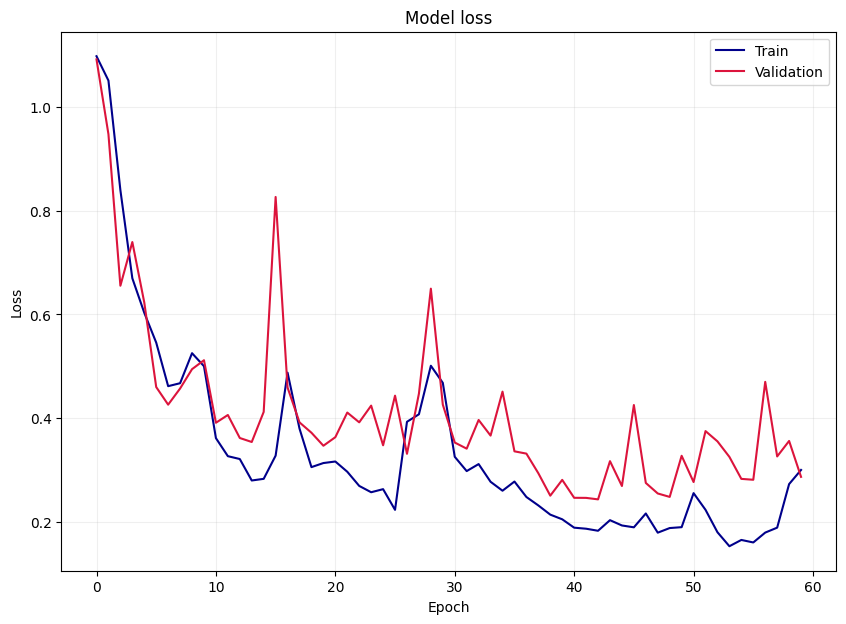

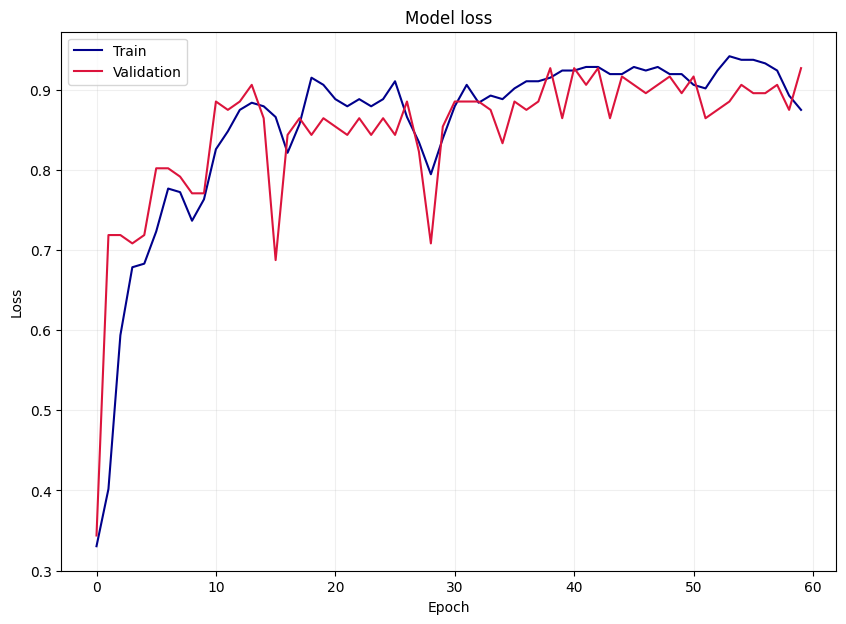

In [ ]:
plot_loss(history)
plot_acc(history)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    plots the confusion matrix
    """
    matrix = confusion_matrix(y_true, y_pred)    
    fig, ax = plt.subplots(figsize=(12,10))
    plt.imshow(matrix)
    ax.set_xticks(range(len(labels)));
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(range(len(labels)));
    ax.set_yticklabels(labels)
    max_confusions = 0
    confused_classes = (-1, -1)
    for i, true_label in enumerate(matrix):
        for j, predicted_label in enumerate(true_label):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="w");
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.title("Confusion Matrix");

In [ ]:
valid_generator = DataGenerator(valid_data, valid_labels, audio_length, batch_size=1, shuffle=False)
y_pred = model.predict(valid_generator, use_multiprocessing=True, workers=6, verbose=1)

98/98 [==============================] - 1s 6ms/step


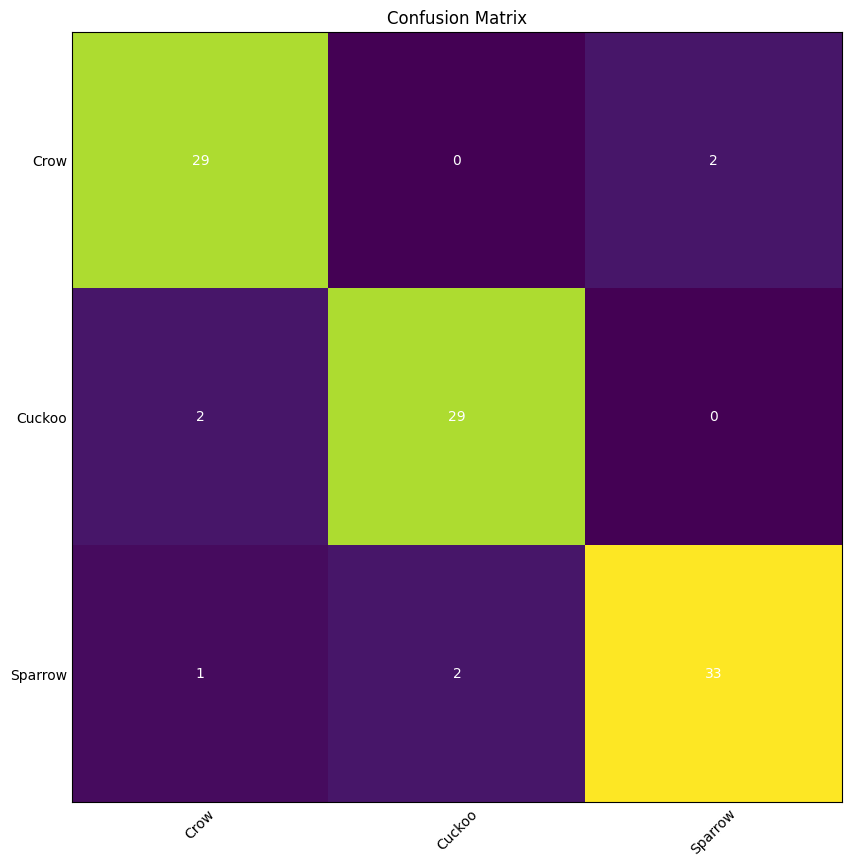

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_true = valid_labels
labels = encoder.classes_
plot_confusion_matrix(y_true, y_pred, labels)

In [ ]:
def remove_noise(audio):
  if audio.ndim > 1:
    audio = np.mean(audio, axis=1)

  f_low = 100
  f_high = 8000

  b, a = signal.butter(4, [f_low / (sampling_rate / 2), f_high / (sampling_rate / 2)], btype='band')
  audio_clean = signal.filtfilt(b, a, audio)
  return audio_clean

In [ ]:
data, _ = librosa.core.load(base_path+'test/crow+cuckoo.wav', sr=sampling_rate, res_type='kaiser_fast')
test = []
for i in range(int(len(data)/audio_length)):
  test.append(data[audio_length*i:audio_length*(i+1)])
data = DataGenerator(test, np.array([0]*len(test)), audio_length, batch_size=1, shuffle=False)
output = model.predict(data, use_multiprocessing=True, workers=6, verbose=1)
labels = encoder.classes_
for i in np.max(output, axis=0):
  print(round(i,2), end='\t')
print('\n', labels)

5/5 [==============================] - 1s 92ms/step
0.8	0.99	0.0	
 ['Crow' 'Cuckoo' 'Sparrow']


In [ ]:
data, _ = librosa.core.load(base_path+'test/crow+sparrow.wav', sr=sampling_rate, res_type='kaiser_fast')
test = []
for i in range(int(len(data)/audio_length)):
  test.append(data[audio_length*i:audio_length*(i+1)])
data = DataGenerator(test, np.array([0]*len(test)), audio_length, batch_size=1, shuffle=False)
output = model.predict(data, use_multiprocessing=True, workers=6, verbose=1)
labels = encoder.classes_
for i in np.max(output, axis=0):
  print(round(i,2), end='\t')
print('\n', labels)

5/5 [==============================] - 1s 58ms/step
1.0	0.0	0.92	
 ['Crow' 'Cuckoo' 'Sparrow']


In [ ]:
data, _ = librosa.core.load(base_path+'test/cuckoo+sparrow.wav', sr=sampling_rate, res_type='kaiser_fast')
test = []
for i in range(int(len(data)/audio_length)):
  test.append(data[audio_length*i:audio_length*(i+1)])
data = DataGenerator(test, np.array([0]*len(test)), audio_length, batch_size=1, shuffle=False)
output = model.predict(data, use_multiprocessing=True, workers=6, verbose=1)
labels = encoder.classes_
for i in np.max(output, axis=0):
  print(round(i,2), end='\t')
print('\n', labels)

3/3 [==============================] - 1s 184ms/step
0.22	1.0	0.87	
 ['Crow' 'Cuckoo' 'Sparrow']


In [ ]:
data, _ = librosa.core.load(base_path+'test/human.wav', sr=sampling_rate, res_type='kaiser_fast')
test = []
for i in range(int(len(data)/audio_length)):
  test.append(data[audio_length*i:audio_length*(i+1)])
data = DataGenerator(test, np.array([0]*len(test)), audio_length, batch_size=1, shuffle=False)
output = model.predict(data, use_multiprocessing=True, workers=6, verbose=1)
labels = encoder.classes_
for i in np.max(output, axis=0):
  print(round(i,2), end='\t')
print('\n', labels)

14/14 [==============================] - 1s 22ms/step
1.0	0.0	0.0	
 ['Crow' 'Cuckoo' 'Sparrow']


In [ ]:
data, _ = librosa.core.load(base_path+'test/all.wav', sr=sampling_rate, res_type='kaiser_fast')
test = []
for i in range(int(len(data)/audio_length)):
  test.append(data[audio_length*i:audio_length*(i+1)])
data = DataGenerator(test, np.array([0]*len(test)), audio_length, batch_size=1, shuffle=False)
output = model.predict(data, use_multiprocessing=True, workers=6, verbose=1)
labels = encoder.classes_
for i in np.max(output, axis=0):
  print(round(i,2), end='\t')
print('\n', labels)

4/4 [==============================] - 1s 114ms/step
1.0	0.1	0.81	
 ['Crow' 'Cuckoo' 'Sparrow']


In [ ]:
data, _ = librosa.core.load(base_path+'test/soundless.wav', sr=sampling_rate, res_type='kaiser_fast')
test = []
for i in range(int(len(data)/audio_length)):
  test.append(data[audio_length*i:audio_length*(i+1)])
data = DataGenerator(test, np.array([0]*len(test)), audio_length, batch_size=1, shuffle=False)
output = model.predict(data, use_multiprocessing=True, workers=6, verbose=1)
labels = encoder.classes_
for i in np.max(output, axis=0):
  print(round(i,2), end='\t')
print('\n', labels)

5/5 [==============================] - 1s 60ms/step
0.79	0.54	0.2	
 ['Crow' 'Cuckoo' 'Sparrow']
